In [1]:
!nvidia-smi

Fri Mar  1 01:04:54 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 545.23.08              Driver Version: 545.23.08    CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 2080        On  | 00000000:01:00.0  On |                  N/A |
| 32%   40C    P8              22W / 215W |    486MiB /  8192MiB |      9%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.chdir('..')
os.getcwd()

'/home/linh/projects/IConNet'

In [4]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:512"
import gc
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import sys
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [5]:
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import pandas as pd

# Scikit learn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)

In [6]:
sr = 16000
data_dir = '../data/data_preprocessed/iemocap/preprocessing/'
data_x = np.load(f'{data_dir}iemocap.audio16k.npy', allow_pickle=True)
data_y = np.load(f'{data_dir}iemocap.label4.npy', allow_pickle=True)

In [7]:
x_train, x_test, y_train, y_test = train_test_split(
    data_x, data_y, test_size=0.2, random_state=42, stratify=data_y)
print("Train: %i" % len(x_train))
print("Test: %i" % len(x_test))

Train: 3948
Test: 988


In [8]:
y_train[0]

'ang'

In [9]:
np.unique(y_train)

array(['ang', 'hap', 'neu', 'sad'], dtype=object)

In [10]:
labels = ['ang', 'neu', 'sad', 'hap']

In [11]:
def label_to_index(word):
    return labels.index(word)
label_to_index(y_train[0])

0

In [12]:
train_set = list(zip(x_train, y_train))
test_set = list(zip(x_test, y_test))

In [13]:
def pad_sequence(batch):
    # Make all tensor in a batch the same length by padding with zeros
    batch = [item.t() for item in batch]
    batch = torch.nn.utils.rnn.pad_sequence(
        batch, batch_first=True, padding_value=0.)
    return batch.permute(0, 2, 1)


def collate_fn(batch, max_duration_in_second=4, sample_rate=sr):
    tensors, targets = [], []

    # Gather in lists, and encode labels as indices
    for waveform, label in batch:
        if max_duration_in_second is not None:
            length = len(waveform)
            max_length = sample_rate * max_duration_in_second
            offset = max(0, (length - max_length) // 2)
            waveform = [waveform[offset: length-offset]]
        tensors += [torch.tensor(
            np.array(waveform, dtype=float).squeeze(), 
            dtype=torch.float32)[None,:]]
        targets += [torch.tensor(label_to_index(label), 
                                 dtype=torch.long)]

    # Group the list of tensors into a batched tensor
    tensors = pad_sequence(tensors)
    targets = torch.stack(targets)

    return tensors, targets

batch_size = 16

if device == "cuda":
    num_workers = 1
    pin_memory = True
else:
    num_workers = 0
    pin_memory = False

train_loader = torch.utils.data.DataLoader(
    train_set,
    batch_size=batch_size,
    shuffle=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory, 
    drop_last=True
)
test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
    collate_fn=collate_fn,
    num_workers=num_workers,
    pin_memory=pin_memory
)

In [14]:
import traceback

In [15]:
from IConNet.nn.model import M13mfcc as M13
from omegaconf import OmegaConf as ocf

model_config_path = 'config/model/m13mfcc128.yaml'
model_config = ocf.load(model_config_path)
print(model_config)
model = M13(config=model_config,
           n_input=1, n_output=len(labels))
model

{'name': 'M13mfcc', 'description': 'FirConv with fftconv', 'mfcc': {'n_mfcc': 128, 'n_fft': 1024, 'hop_length': 128, 'n_mels': 128, 'sample_rate': 16000}, 'pooling': 'mean', 'cls': {'n_block': 2, 'n_hidden_dim': [512, 512], 'norm_type': 'LayerNorm'}}


M13mfcc(
  (mfcc): MFCC(
    (amplitude_to_DB): AmplitudeToDB()
    (MelSpectrogram): MelSpectrogram(
      (spectrogram): Spectrogram()
      (mel_scale): MelScale()
    )
  )
  (cls_head): Classifier(
    (blocks): ModuleList(
      (0): Sequential(
        (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=128, out_features=512, bias=True)
      )
      (1): Sequential(
        (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
        (layer): Linear(in_features=512, out_features=512, bias=True)
      )
    )
    (act): LeakyReLU(negative_slope=0.01)
    (output_layer): Linear(in_features=512, out_features=4, bias=True)
  )
)

In [16]:
n_epoch = 10
train_losses = []
test_accuracy = []
optimizer = optim.RAdam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.1,
    steps_per_epoch=len(train_loader), epochs=n_epoch)

In [17]:
train_loader_length = len(train_loader.dataset)
test_loader_length = len(test_loader.dataset)

def train(model, epoch, log_interval, 
          train_losses=train_losses):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        try:
            _mem_before = torch.cuda.memory_allocated()
            data = data.to(device)
            target = target.to(device)
            output = model(data)
            del data
            gc.collect()
            torch.cuda.empty_cache()
            loss = F.cross_entropy(output.squeeze(), target)
            _mem_during = torch.cuda.memory_allocated()
            del target
            gc.collect()
            torch.cuda.empty_cache()
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad.clip_grad_norm_(
                model.parameters(), 1.0)
            optimizer.step()
            _mem_after = torch.cuda.memory_allocated()
            # print training stats
            if batch_idx % log_interval == 0:
                print(f"Train Epoch: {epoch} [{batch_idx * batch_size}/{train_loader_length} ({100. * batch_idx / len(train_loader):.0f}%)]\tLoss: {loss.item():.6f}")
                print(f'Mem before-during-after: {_mem_before} {_mem_during} {_mem_after}')
            # update progress bar
            pbar.update(pbar_update)
            # record loss
            train_losses.append(loss.item())
        except Exception as e:
            print(f'data: {data.shape} => output: {output.shape} | target: {target.shape}')
            traceback.print_exc()

@torch.no_grad
def test(model, epoch):
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    acc = correct / test_loader_length
    print(f"\nTest Epoch: {epoch}\tAccuracy: {correct}/{total} ({100. * acc:.0f}%)\n")
    return acc

In [18]:
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
model.to(device)
with tqdm(total=n_epoch) as pbar:
    for epoch in range(1, n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        scheduler.step()

  0%|                                  | 0.006514657980456026/10 [00:00<12:19, 73.99s/it]

Train Epoch: 1 [0/3948 (0%)]	Loss: 1.374608
Mem before-during-after: 1660928 10332672 22687232


  1%|▍                                  | 0.13680781758957658/10 [00:07<08:16, 50.37s/it]

Train Epoch: 1 [640/3948 (16%)]	Loss: 1.779455
Mem before-during-after: 22687232 22838272 22687232


  3%|▉                                  | 0.26710097719869713/10 [00:14<08:13, 50.66s/it]

Train Epoch: 1 [1280/3948 (33%)]	Loss: 1.468293
Mem before-during-after: 22687232 22838272 22687232


  4%|█▍                                  | 0.3941368078175897/10 [00:21<08:17, 51.74s/it]

Train Epoch: 1 [1920/3948 (49%)]	Loss: 1.379919
Mem before-during-after: 22687232 22838272 22687232


  5%|█▉                                  | 0.5276872964169382/10 [00:27<08:07, 51.45s/it]

Train Epoch: 1 [2560/3948 (65%)]	Loss: 0.997636
Mem before-during-after: 22687232 22838272 22687232


  7%|██▎                                 | 0.6579804560260588/10 [00:34<07:46, 49.92s/it]

Train Epoch: 1 [3200/3948 (81%)]	Loss: 1.360587
Mem before-during-after: 22687232 22838272 22687232


  8%|██▊                                 | 0.7882736156351794/10 [00:41<08:01, 52.31s/it]

Train Epoch: 1 [3840/3948 (98%)]	Loss: 1.240784
Mem before-during-after: 22687232 22838272 22687232


 10%|███▌                                | 1.0032573289902282/10 [00:52<07:47, 51.94s/it]


Test Epoch: 1	Accuracy: 494/976 (50%)

Train Epoch: 2 [0/3948 (0%)]	Loss: 0.994789
Mem before-during-after: 22686208 22838272 22687232


 11%|████                                | 1.1368078175895768/10 [00:59<07:27, 50.51s/it]

Train Epoch: 2 [640/3948 (16%)]	Loss: 0.795548
Mem before-during-after: 22687232 22838272 22687232


 13%|████▌                               | 1.2671009771986974/10 [01:06<07:28, 51.34s/it]

Train Epoch: 2 [1280/3948 (33%)]	Loss: 1.136117
Mem before-during-after: 22687232 22838272 22687232


 14%|█████▏                               | 1.397394136807818/10 [01:13<07:13, 50.34s/it]

Train Epoch: 2 [1920/3948 (49%)]	Loss: 1.360763
Mem before-during-after: 22687232 22838272 22687232


 15%|█████▍                              | 1.5276872964169386/10 [01:20<07:17, 51.65s/it]

Train Epoch: 2 [2560/3948 (65%)]	Loss: 1.174399
Mem before-during-after: 22687232 22838272 22687232


 17%|█████▉                              | 1.6579804560260591/10 [01:26<06:48, 49.01s/it]

Train Epoch: 2 [3200/3948 (81%)]	Loss: 0.649122
Mem before-during-after: 22687232 22838272 22687232


 18%|██████▍                             | 1.7882736156351797/10 [01:33<06:48, 49.79s/it]

Train Epoch: 2 [3840/3948 (98%)]	Loss: 1.602451
Mem before-during-after: 22687232 22838272 22687232


 20%|███████▏                            | 2.0032573289902285/10 [01:44<06:47, 51.00s/it]


Test Epoch: 2	Accuracy: 492/976 (50%)

Train Epoch: 3 [0/3948 (0%)]	Loss: 0.927943
Mem before-during-after: 22686208 22838272 22687232


 21%|███████▉                             | 2.136807817589577/10 [01:51<06:44, 51.46s/it]

Train Epoch: 3 [640/3948 (16%)]	Loss: 1.331651
Mem before-during-after: 22687232 22838272 22687232


 23%|████████▏                           | 2.2671009771986976/10 [01:57<06:34, 51.06s/it]

Train Epoch: 3 [1280/3948 (33%)]	Loss: 1.306680
Mem before-during-after: 22687232 22838272 22687232


 24%|████████▊                            | 2.397394136807818/10 [02:04<06:31, 51.54s/it]

Train Epoch: 3 [1920/3948 (49%)]	Loss: 1.195388
Mem before-during-after: 22687232 22838272 22687232


 25%|█████████▎                           | 2.527687296416939/10 [02:11<06:19, 50.81s/it]

Train Epoch: 3 [2560/3948 (65%)]	Loss: 1.277788
Mem before-during-after: 22687232 22838272 22687232


 27%|█████████▌                          | 2.6579804560260594/10 [02:18<06:08, 50.13s/it]

Train Epoch: 3 [3200/3948 (81%)]	Loss: 0.816668
Mem before-during-after: 22687232 22838272 22687232


 28%|██████████▌                           | 2.78827361563518/10 [02:24<06:06, 50.82s/it]

Train Epoch: 3 [3840/3948 (98%)]	Loss: 0.762336
Mem before-during-after: 22687232 22838272 22687232


 30%|███████████                          | 3.003257328990229/10 [02:35<05:48, 49.75s/it]


Test Epoch: 3	Accuracy: 553/976 (56%)

Train Epoch: 4 [0/3948 (0%)]	Loss: 1.117130
Mem before-during-after: 22686208 22838272 22687232


 31%|███████████▎                        | 3.1368078175895775/10 [02:42<05:59, 52.40s/it]

Train Epoch: 4 [640/3948 (16%)]	Loss: 0.956206
Mem before-during-after: 22687232 22838272 22687232


 33%|████████████                         | 3.267100977198698/10 [02:49<05:39, 50.35s/it]

Train Epoch: 4 [1280/3948 (33%)]	Loss: 0.700162
Mem before-during-after: 22687232 22838272 22687232


 34%|████████████▏                       | 3.3973941368078187/10 [02:56<05:42, 51.89s/it]

Train Epoch: 4 [1920/3948 (49%)]	Loss: 1.383126
Mem before-during-after: 22687232 22838272 22687232


 35%|████████████▋                       | 3.5276872964169392/10 [03:02<05:18, 49.23s/it]

Train Epoch: 4 [2560/3948 (65%)]	Loss: 1.306202
Mem before-during-after: 22687232 22838272 22687232


 37%|█████████████▉                        | 3.65798045602606/10 [03:09<05:45, 54.40s/it]

Train Epoch: 4 [3200/3948 (81%)]	Loss: 1.193316
Mem before-during-after: 22687232 22838272 22687232


 38%|█████████████▋                      | 3.7882736156351804/10 [03:16<05:12, 50.23s/it]

Train Epoch: 4 [3840/3948 (98%)]	Loss: 0.864708
Mem before-during-after: 22687232 22838272 22687232


 40%|██████████████▍                     | 4.0032573289902285/10 [03:27<05:03, 50.59s/it]


Test Epoch: 4	Accuracy: 534/976 (54%)

Train Epoch: 5 [0/3948 (0%)]	Loss: 1.036384
Mem before-during-after: 22686208 22838272 22687232


 41%|███████████████▎                     | 4.136807817589559/10 [03:34<05:13, 53.41s/it]

Train Epoch: 5 [640/3948 (16%)]	Loss: 1.012032
Mem before-during-after: 22687232 22838272 22687232


 43%|███████████████▊                     | 4.267100977198662/10 [03:41<05:10, 54.21s/it]

Train Epoch: 5 [1280/3948 (33%)]	Loss: 1.048259
Mem before-during-after: 22687232 22838272 22687232


 44%|███████████████▊                    | 4.3973941368077645/10 [03:48<04:56, 52.91s/it]

Train Epoch: 5 [1920/3948 (49%)]	Loss: 0.948088
Mem before-during-after: 22687232 22838272 22687232


 45%|████████████████▊                    | 4.527687296416867/10 [03:54<04:48, 52.67s/it]

Train Epoch: 5 [2560/3948 (65%)]	Loss: 1.266333
Mem before-during-after: 22687232 22838272 22687232


 47%|█████████████████▋                    | 4.65798045602597/10 [04:01<04:30, 50.67s/it]

Train Epoch: 5 [3200/3948 (81%)]	Loss: 0.803715
Mem before-during-after: 22687232 22838272 22687232


 48%|█████████████████▋                   | 4.788273615635073/10 [04:08<04:23, 50.46s/it]

Train Epoch: 5 [3840/3948 (98%)]	Loss: 1.408311
Mem before-during-after: 22687232 22838272 22687232


 50%|██████████████████▌                  | 5.003257328990093/10 [04:19<04:11, 50.43s/it]


Test Epoch: 5	Accuracy: 517/976 (52%)

Train Epoch: 6 [0/3948 (0%)]	Loss: 0.915972
Mem before-during-after: 22686208 22838272 22687232


 51%|███████████████████                  | 5.136807817589423/10 [04:26<04:20, 53.55s/it]

Train Epoch: 6 [640/3948 (16%)]	Loss: 0.664382
Mem before-during-after: 22687232 22838272 22687232


 53%|███████████████████▍                 | 5.267100977198526/10 [04:32<03:54, 49.55s/it]

Train Epoch: 6 [1280/3948 (33%)]	Loss: 1.003540
Mem before-during-after: 22687232 22838272 22687232


 54%|███████████████████▉                 | 5.397394136807629/10 [04:39<03:59, 51.96s/it]

Train Epoch: 6 [1920/3948 (49%)]	Loss: 1.063464
Mem before-during-after: 22687232 22838272 22687232


 55%|████████████████████▍                | 5.527687296416731/10 [04:46<03:50, 51.43s/it]

Train Epoch: 6 [2560/3948 (65%)]	Loss: 0.867733
Mem before-during-after: 22687232 22838272 22687232


 57%|████████████████████▉                | 5.657980456025834/10 [04:53<03:42, 51.17s/it]

Train Epoch: 6 [3200/3948 (81%)]	Loss: 0.815039
Mem before-during-after: 22687232 22838272 22687232


 58%|█████████████████████▍               | 5.788273615634937/10 [05:00<03:40, 52.38s/it]

Train Epoch: 6 [3840/3948 (98%)]	Loss: 0.829668
Mem before-during-after: 22687232 22838272 22687232


 60%|██████████████████████▏              | 6.003257328989957/10 [05:11<03:26, 51.61s/it]


Test Epoch: 6	Accuracy: 545/976 (55%)

Train Epoch: 7 [0/3948 (0%)]	Loss: 0.904907
Mem before-during-after: 22686208 22838272 22687232


 61%|██████████████████████▋              | 6.136807817589287/10 [05:17<03:22, 52.53s/it]

Train Epoch: 7 [640/3948 (16%)]	Loss: 0.973641
Mem before-during-after: 22687232 22838272 22687232


 63%|███████████████████████▊              | 6.26710097719839/10 [05:24<03:14, 51.98s/it]

Train Epoch: 7 [1280/3948 (33%)]	Loss: 1.104930
Mem before-during-after: 22687232 22838272 22687232


 64%|███████████████████████▋             | 6.397394136807493/10 [05:31<03:07, 51.94s/it]

Train Epoch: 7 [1920/3948 (49%)]	Loss: 0.688457
Mem before-during-after: 22687232 22838272 22687232


 65%|███████████████████████▍            | 6.5276872964165955/10 [05:38<03:08, 54.37s/it]

Train Epoch: 7 [2560/3948 (65%)]	Loss: 0.907610
Mem before-during-after: 22687232 22838272 22687232


 67%|████████████████████████▋            | 6.657980456025698/10 [05:44<02:49, 50.84s/it]

Train Epoch: 7 [3200/3948 (81%)]	Loss: 0.915900
Mem before-during-after: 22687232 22838272 22687232


 68%|█████████████████████████            | 6.788273615634801/10 [05:51<02:44, 51.34s/it]

Train Epoch: 7 [3840/3948 (98%)]	Loss: 1.001358
Mem before-during-after: 22687232 22838272 22687232


 70%|█████████████████████████▉           | 7.003257328989821/10 [06:02<02:36, 52.33s/it]


Test Epoch: 7	Accuracy: 570/976 (58%)

Train Epoch: 8 [0/3948 (0%)]	Loss: 1.071656
Mem before-during-after: 22686208 22838272 22687232


 71%|██████████████████████████▍          | 7.136807817589151/10 [06:09<02:32, 53.41s/it]

Train Epoch: 8 [640/3948 (16%)]	Loss: 0.811958
Mem before-during-after: 22687232 22838272 22687232


 73%|██████████████████████████▉          | 7.267100977198254/10 [06:16<02:18, 50.70s/it]

Train Epoch: 8 [1280/3948 (33%)]	Loss: 1.489404
Mem before-during-after: 22687232 22838272 22687232


 74%|███████████████████████████▎         | 7.394136807817129/10 [06:22<02:11, 50.54s/it]

Train Epoch: 8 [1920/3948 (49%)]	Loss: 0.932665
Mem before-during-after: 22687232 22838272 22687232


 75%|████████████████████████████▌         | 7.52768729641646/10 [06:29<02:05, 50.87s/it]

Train Epoch: 8 [2560/3948 (65%)]	Loss: 1.166256
Mem before-during-after: 22687232 22838272 22687232


 77%|████████████████████████████▎        | 7.654723127035335/10 [06:36<01:58, 50.56s/it]

Train Epoch: 8 [3200/3948 (81%)]	Loss: 0.952747
Mem before-during-after: 22687232 22838272 22687232


 78%|████████████████████████████▊        | 7.788273615634665/10 [06:43<01:53, 51.45s/it]

Train Epoch: 8 [3840/3948 (98%)]	Loss: 0.711548
Mem before-during-after: 22687232 22838272 22687232


 80%|█████████████████████████████▌       | 8.003257328989685/10 [06:54<01:39, 49.79s/it]


Test Epoch: 8	Accuracy: 556/976 (56%)

Train Epoch: 9 [0/3948 (0%)]	Loss: 0.893723
Mem before-during-after: 22686208 22838272 22687232


 81%|██████████████████████████████       | 8.136807817589052/10 [07:01<01:39, 53.31s/it]

Train Epoch: 9 [640/3948 (16%)]	Loss: 0.544178
Mem before-during-after: 22687232 22838272 22687232


 83%|███████████████████████████████▍      | 8.26710097719819/10 [07:08<01:26, 50.18s/it]

Train Epoch: 9 [1280/3948 (33%)]	Loss: 0.857697
Mem before-during-after: 22687232 22838272 22687232


 84%|███████████████████████████████      | 8.397394136807328/10 [07:15<01:23, 52.18s/it]

Train Epoch: 9 [1920/3948 (49%)]	Loss: 1.060351
Mem before-during-after: 22687232 22838272 22687232


 85%|███████████████████████████████▌     | 8.527687296416467/10 [07:21<01:16, 51.86s/it]

Train Epoch: 9 [2560/3948 (65%)]	Loss: 0.954807
Mem before-during-after: 22687232 22838272 22687232


 87%|████████████████████████████████     | 8.657980456025605/10 [07:28<01:06, 49.77s/it]

Train Epoch: 9 [3200/3948 (81%)]	Loss: 1.040366
Mem before-during-after: 22687232 22838272 22687232


 88%|████████████████████████████████▌    | 8.788273615634743/10 [07:35<01:04, 53.17s/it]

Train Epoch: 9 [3840/3948 (98%)]	Loss: 1.151316
Mem before-during-after: 22687232 22838272 22687232


 90%|█████████████████████████████████▎   | 9.003257328989822/10 [07:46<00:51, 51.39s/it]


Test Epoch: 9	Accuracy: 581/976 (59%)

Train Epoch: 10 [0/3948 (0%)]	Loss: 0.598785
Mem before-during-after: 22686208 22838272 22687232


 91%|█████████████████████████████████▊   | 9.136807817589188/10 [07:53<00:43, 50.72s/it]

Train Epoch: 10 [640/3948 (16%)]	Loss: 1.068953
Mem before-during-after: 22687232 22838272 22687232


 93%|██████████████████████████████████▎  | 9.267100977198327/10 [08:00<00:38, 51.94s/it]

Train Epoch: 10 [1280/3948 (33%)]	Loss: 0.968307
Mem before-during-after: 22687232 22838272 22687232


 94%|██████████████████████████████████▊  | 9.397394136807465/10 [08:07<00:37, 62.96s/it]

Train Epoch: 10 [1920/3948 (49%)]	Loss: 0.598056
Mem before-during-after: 22687232 22838272 22687232


 95%|███████████████████████████████████▎ | 9.527687296416604/10 [08:14<00:23, 49.97s/it]

Train Epoch: 10 [2560/3948 (65%)]	Loss: 0.690583
Mem before-during-after: 22687232 22838272 22687232


 97%|███████████████████████████████████▋ | 9.657980456025742/10 [08:20<00:17, 50.96s/it]

Train Epoch: 10 [3200/3948 (81%)]	Loss: 0.701632
Mem before-during-after: 22687232 22838272 22687232


 98%|█████████████████████████████████████▏| 9.78827361563488/10 [08:27<00:10, 51.94s/it]

Train Epoch: 10 [3840/3948 (98%)]	Loss: 1.159974
Mem before-during-after: 22687232 22838272 22687232


100%|█████████████████████████████████████▉| 9.99999999999973/10 [08:38<00:00, 51.86s/it]


Test Epoch: 10	Accuracy: 561/976 (57%)



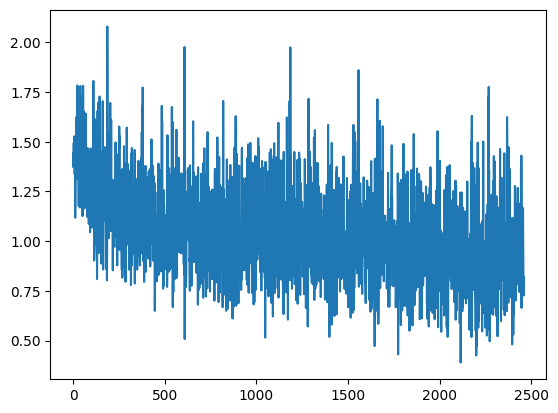

In [19]:
plt.plot(train_losses)

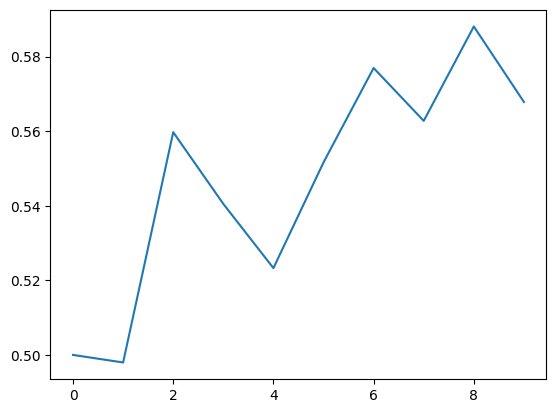

In [20]:
plt.plot(test_accuracy)

In [23]:
from torchmetrics.classification import (
    MulticlassAccuracy, MulticlassPrecision, 
    MulticlassRecall, MulticlassF1Score, 
    MulticlassConfusionMatrix,
    MulticlassAUROC
)
from torchmetrics import MetricCollection
from pprint import pprint

@torch.no_grad
def report_metrics(model, labels=labels, 
                   test_loader=test_loader, device=device):
    n = len(labels)
    metrics = MetricCollection({
        'acc_unweighted': MulticlassAccuracy(num_classes=n, average='macro'), 
        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        
        'f1s_unweighted': MulticlassF1Score(num_classes=n, average='macro'),  
        'f1s_weighted': MulticlassF1Score(num_classes=n, average='weighted'),  

        'acc_weighted': MulticlassAccuracy(num_classes=n, average='weighted'), 
        'uar': MulticlassRecall(num_classes=n, average='macro'), 
        'wap': MulticlassPrecision(num_classes=n, average='weighted'),
        'rocauc': MulticlassAUROC(num_classes=n, average='macro', thresholds=None),    
        'f1s_detail': MulticlassF1Score(num_classes=n, average=None),  
        'acc_detail': MulticlassAccuracy(num_classes=n, average=None), 
        'precision_detail': MulticlassPrecision(num_classes=n, average=None),
        'recall_detail': MulticlassRecall(num_classes=n, average=None), 
        'rocauc_detail': MulticlassAUROC(num_classes=n, average=None, thresholds=None),
    }).to(device)
    confusion_matrix = MulticlassConfusionMatrix(num_classes=n).to(device)
    model.eval()
    correct = 0
    total = 0
    for data, target in test_loader:
        total += len(target)
        
        data = data.to(device)
        target = target.to(device)
        output = model(data).squeeze()
        del data
        gc.collect()
        torch.cuda.empty_cache()
        probs = F.softmax(output, dim=-1)
        pred = probs.argmax(dim=-1)
        correct += pred.eq(target).sum().item()
        
        metrics.update(probs, target)
        confusion_matrix.update(pred, target)
        
        del target
        gc.collect()
        torch.cuda.empty_cache()
        pbar.update(pbar_update)
    print(f'Correct: {correct}/{total} ({correct/total:.4f})')
    return metrics, confusion_matrix

In [24]:
metrics, confusion_matrix = report_metrics(
    model, labels=labels, device=device)
pprint(metrics.compute())
confusion_matrix.compute()

Correct: 561/976 (0.5748)
{'acc_detail': tensor([0.4615, 0.5769, 0.5514, 0.7192], device='cuda:0'),
 'acc_unweighted': tensor(0.5773, device='cuda:0'),
 'acc_weighted': tensor(0.5748, device='cuda:0'),
 'f1s_detail': tensor([0.5589, 0.5945, 0.6501, 0.5141], device='cuda:0'),
 'f1s_unweighted': tensor(0.5794, device='cuda:0'),
 'f1s_weighted': tensor(0.5819, device='cuda:0'),
 'precision_detail': tensor([0.7083, 0.6132, 0.7919, 0.4000], device='cuda:0'),
 'recall_detail': tensor([0.4615, 0.5769, 0.5514, 0.7192], device='cuda:0'),
 'rocauc': tensor(0.8340, device='cuda:0'),
 'rocauc_detail': tensor([0.8540, 0.7850, 0.9090, 0.7880], device='cuda:0'),
 'uar': tensor(0.5773, device='cuda:0'),
 'wap': tensor(0.6296, device='cuda:0')}


tensor([[102,  35,   1,  83],
        [ 12, 195,  25, 106],
        [ 11,  55, 118,  30],
        [ 19,  33,   5, 146]], device='cuda:0')

In [25]:
model_path = '../models_iemocap4/iemocap4__m13mfcc128_10epochs.pt' 
torch.save(model.state_dict(), model_path)

In [ ]:
n_epoch = 10
n_epoch2 = 50
# train_losses = []
# test_accuracy = []
best_accuracy = test_accuracy[-1]
best_epoch = n_epoch
model_path_prefix = '../models_iemocap4/iemocap4_m18emo4_best_'

optimizer = optim.RAdam(model.parameters(), lr=0.00002)
scheduler = optim.lr_scheduler.OneCycleLR(
    optimizer, max_lr=0.01,
    steps_per_epoch=len(train_loader), epochs=n_epoch2)
log_interval = 40
pbar_update = 1 / (len(train_loader) + len(test_loader))
# model.to(device)
with tqdm(total=n_epoch2) as pbar:
    for epoch in range(1+n_epoch, n_epoch2 + n_epoch + 1):
        train(model, epoch, log_interval, train_losses)
        acc = test(model, epoch)
        test_accuracy += [acc]
        if acc > best_accuracy:
            best_accuracy = acc
            best_epoch = epoch
            bmodel_path = f'{model_path_prefix}{epoch}epoch.pt'
            torch.save(model.state_dict(), bmodel_path)
            print(f'saved model: {bmodel_path}')
        scheduler.step()

In [ ]:
plt.plot(train_losses)

In [ ]:
plt.plot(test_accuracy)

In [ ]:
metrics2, confusion_matrix2 = report_metrics(
    model, labels=labels, device=device)
pprint(metrics2.compute())
confusion_matrix2.compute()

In [ ]:
model.to('cpu')
best_model_path = f'{model_path_prefix}{best_epoch}epoch.pt'
print(best_model_path)
best_model = M18(config=model_config,
           n_input=1, n_output=len(labels))
best_model.load_state_dict(torch.load(best_model_path))
best_model.to(device)

metrics_best, confusion_matrix_best = report_metrics(
    best_model, labels=labels, device=device)
best_model.to('cpu')
pprint(metrics_best.compute())
confusion_matrix_best.compute()

In [ ]:
checkpoint_path = f'../models_iemocap4/iemocap4_m13mfcc128_{epoch}epoch.ckpt'
torch.save({
    'epoch': epoch,
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
    'loss': train_losses[-1],
    'best_epoch': best_epoch,
    'best_accuracy': best_accuracy,
    'train_losses': train_losses,
    'test_accuracy': test_accuracy,
    'log_interval': log_interval,
    }, checkpoint_path)